In [0]:
#mount google drive
from google.colab import drive
drive.mount("/content/drive")
import os
os.chdir("/content/drive/My Drive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn import preprocessing

In [0]:
#import data
import numpy as np, pandas as pd
train_identity = pd.read_csv("train_identity.csv")
train_transaction = pd. read_csv("train_transaction.csv")
test_identity = pd.read_csv("test_identity.csv")
test_transaction = pd. read_csv("test_transaction.csv")

train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [0]:
#change test dataset id columns from hyphen to underline
test = test.rename(columns={'id-01':'id_01', 'id-02':'id_02', 'id-03':'id_03', 'id-04':'id_04','id-05': 'id_05',
       'id-06':'id_06', 'id-07': 'id_07', 'id-08': 'id_08', 'id-09': 'id_09', 'id-10': 'id_10', 
       'id-11': 'id_11', 'id-12': 'id_12', 'id-13':'id_13',
       'id-14':'id_14', 'id-15':'id_15', 'id-16':'id_16', 'id-17':'id_17', 'id-18':'id_18', 'id-19':'id_19', 
       'id-20':'id_20', 'id-21':'id_21','id-22':'id_22', 'id-23':'id_23', 'id-24':'id_24', 'id-25':'id_25', 
       'id-26':'id_26', 'id-27':'id_27', 'id-28':'id_28', 'id-29':'id_29',
       'id-30':'id_30', 'id-31':'id_31', 'id-32':'id_32', 'id-33':'id_33', 'id-34':'id_34', 'id-35':'id_35', 
       'id-36':'id_36', 'id-37':'id_37',
       'id-38':'id_38'})

test.head()


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Feature Engineering

In [0]:
#Add mean and standard deviation of transaction amount, id and time delta; grouped by card and address
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')
train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('std')

In [0]:
#split domain with "."
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

In [0]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,...,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_mean_card4,id_02_to_std_card1,id_02_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_mean_addr2,D15_to_std_addr1,D15_to_std_addr2,P_emaildomain_1,P_emaildomain_2,R_emaildomain_1,R_emaildomain_2
0,2987000,0,86400,68.5,4,4248,501,50,1,42,1,215,80,19.0,32,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,...,55,28,3,2,127,568,547,2,2,86,136,6,461,4,2,2,2,2,2,2740,0.194640,0.257761,0.184566,0.170233,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25,7,25,7
1,2987001,0,86401,29.0,4,9979,304,50,2,2,1,225,80,NaN,16,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,55,28,3,2,127,568,547,2,2,86,136,6,461,4,2,2,2,2,2,2740,0.123777,0.219054,0.062995,0.114212,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15,2,25,7
2,2987002,0,86469,59.0,4,11850,390,50,4,66,2,230,80,287.0,36,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,...,55,28,3,2,127,568,547,2,2,86,136,6,461,4,2,2,2,2,2,2740,0.608150,0.443070,0.589241,0.258544,NaN,NaN,NaN,NaN,2.518583,1.865915,1.851016,1.541448,1.611525,1.721392,1.486472,1.522249,28,2,25,7
3,2987003,0,86499,50.0,4,8796,467,50,2,17,2,376,80,NaN,55,32,2.0,5.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,NaN,...,55,28,3,2,127,568,547,2,2,86,136,6,461,4,2,2,2,2,2,2740,0.405133,0.377679,0.259447,0.196917,NaN,NaN,NaN,NaN,0.550272,0.720057,0.520531,0.558392,0.686169,0.606586,0.576638,0.536412,44,2,25,7
4,2987004,0,86506,50.0,1,11687,414,50,2,2,1,320,80,NaN,16,32,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55,7,1,1,65,438,44,1,1,7,162,3,268,3,1,0,1,1,1,1565,0.515612,0.377679,0.882933,0.196917,0.764773,0.373295,1.753301,0.425884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,2,25,7


Modeling Preparation

In [0]:
#collect columns with too many missing values
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

In [0]:
#collect columns with only one value
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

False

In [0]:
#collect columns with outliers
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [0]:
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

84

In [0]:
#drop all the collected columns
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [0]:
#collect categorical columns and transfer them into numbers
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in train.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

In [0]:
#split X and y
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
#X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)
#del train
test = test[["TransactionDT", 'TransactionID']]

In [0]:
# by https://www.kaggle.com/dimartinot
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Clean infinite values to NaN
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test)

In [0]:
gc.collect()

150

LGBM

In [0]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

In [0]:
#functions used for the models
def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True

def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - train data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
      # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)
            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            print(model.get_score(importance_type='weight'))
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=Logloss)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index
            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols

    
    return result_dict

In [0]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

'params = {\'num_leaves\': 256,\n          \'min_child_samples\': 79,\n          \'objective\': \'binary\',\n          \'max_depth\': 13,\n          \'learning_rate\': 0.03,\n          "boosting_type": "gbdt",\n          "subsample_freq": 3,\n          "subsample": 0.9,\n          "bagging_seed": 11,\n          "metric": \'auc\',\n          "verbosity": -1,\n          \'reg_alpha\': 0.3,\n          \'reg_lambda\': 0.3,\n          \'colsample_bytree\': 0.9,\n          #\'categorical_feature\': cat_cols\n         }\nresult_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type=\'lgb\', eval_metric=\'auc\', plot_feature_importance=True,\n                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging=\'usual\', n_jobs=-1)'

In [0]:
#use GPU to run xgboost
xgb_params = {'eta': 0.04,
               'max_depth': 5,
               'subsample': 0.85,
               'objective': 'binary:logistic',
               'eval_metric': 'auc',
               'silent': True,
               'nthread': -1,
               'tree_method': 'gpu_hist'}
result_dict_xgb = train_model_classification(X=X, X_test=X_test, y=y, params=xgb_params, folds=folds, model_type='xgb', eval_metric='auc', plot_feature_importance=False,
                                                       verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='rank')

Fold 1 started at Fri Mar  6 00:07:59 2020


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.765415	valid_data-auc:0.772437
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.938983	valid_data-auc:0.893402
[1000]	train-auc:0.959041	valid_data-auc:0.905084
[1500]	train-auc:0.970853	valid_data-auc:0.91018
[2000]	train-auc:0.977991	valid_data-auc:0.911919
Stopping. Best iteration:
[2171]	train-auc:0.980102	valid_data-auc:0.91262

{'V258': 71, 'C12': 270, 'V156': 50, 'C14': 647, 'C1': 1029, 'V294': 173, 'V149': 47, 'V194': 31, 'R_emaildomain': 506, 'C13': 1292, 'C11': 619, 'V314': 318, 'C8': 300, 'card2': 2348, 'V323': 36, 'V225': 20, 'V232': 31, 'card3': 299, 'V256': 49, 'DeviceInfo': 740, 'V326': 27, 'D13': 281, 'V220': 81, 'V283': 179, 'card1': 3038, 'id_13': 384, 'TransactionAmt': 898, 'V169': 57, 'V201': 49, 'V171': 34, 'D2': 1162, 'id_14': 158, 'V62': 218, 'V246': 35, 'V143': 38, 'V327': 11, 'addr2': 25, 'V87': 306, 'V224': 48, 'V239': 23, 

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.768715	valid_data-auc:0.780718
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.938764	valid_data-auc:0.908924
[1000]	train-auc:0.958017	valid_data-auc:0.917354
[1500]	train-auc:0.969674	valid_data-auc:0.920407
[2000]	train-auc:0.977771	valid_data-auc:0.92239
[2500]	train-auc:0.983082	valid_data-auc:0.923221
Stopping. Best iteration:
[2350]	train-auc:0.981621	valid_data-auc:0.923396

{'V258': 78, 'C12': 284, 'V149': 57, 'V294': 232, 'C14': 633, 'V313': 561, 'V156': 68, 'card3': 282, 'V147': 28, 'C13': 1285, 'C1': 1032, 'V223': 10, 'V72': 16, 'V45': 192, 'V227': 19, 'V155': 9, 'V238': 18, 'V61': 157, 'V197': 23, 'V56': 161, 'V130': 292, 'V169': 48, 'D13': 247, 'V200': 55, 'C7': 110, 'V317': 321, 'id_01': 436, 'V212': 51, 'D15_to_std_card1': 671, 'V190': 21, 'V201': 55, 'V244': 16, 'C8': 304, 'V38': 214, 'D15_to_std_card4': 118, 'V170': 40, 'card1': 3

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.770118	valid_data-auc:0.753948
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.940285	valid_data-auc:0.905204
[1000]	train-auc:0.959979	valid_data-auc:0.914972
[1500]	train-auc:0.971648	valid_data-auc:0.918018
[2000]	train-auc:0.978938	valid_data-auc:0.918718
Stopping. Best iteration:
[1994]	train-auc:0.978894	valid_data-auc:0.918738

{'V258': 84, 'V189': 47, 'V45': 205, 'V294': 213, 'C14': 549, 'C12': 259, 'R_emaildomain': 416, 'D15_to_std_card1': 623, 'C2': 612, 'C1': 837, 'V323': 40, 'TransactionAmt_to_std_card4': 852, 'C13': 1157, 'C11': 581, 'V175': 14, 'V156': 53, 'V245': 46, 'V61': 168, 'card3': 307, 'V257': 25, 'V99': 108, 'D13': 189, 'V266': 103, 'id_37': 64, 'C8': 277, 'V78': 185, 'TransactionAmt_to_mean_card4': 747, 'V209': 50, 'V255': 14, 'V317': 290, 'DeviceInfo': 736, 'V335': 48, 'V313': 478, 'V149': 71, 'ProductCD': 213, 'V152': 44, 

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.773239	valid_data-auc:0.780158
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.935788	valid_data-auc:0.924277
[1000]	train-auc:0.956693	valid_data-auc:0.932738
[1500]	train-auc:0.969535	valid_data-auc:0.937502
[2000]	train-auc:0.977567	valid_data-auc:0.939364
[2500]	train-auc:0.983165	valid_data-auc:0.940298
Stopping. Best iteration:
[2510]	train-auc:0.983248	valid_data-auc:0.940381

{'V258': 80, 'V189': 40, 'C12': 276, 'C14': 664, 'C1': 1043, 'V294': 253, 'C13': 1344, 'C11': 627, 'V45': 215, 'V197': 11, 'V323': 59, 'V207': 74, 'D2': 1279, 'TransactionAmt_to_mean_card1': 1367, 'V156': 60, 'id_19': 726, 'V225': 32, 'DeviceInfo': 880, 'V201': 46, 'V198': 20, 'V130': 345, 'V223': 17, 'D13': 233, 'V246': 14, 'V244': 29, 'C8': 274, 'V283': 204, 'D15_to_std_card1': 779, 'V170': 55, 'id_02_to_std_card1': 410, 'V332': 83, 'V190': 11, 'V187': 62, 'V208': 71

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.74453	valid_data-auc:0.731931
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.939678	valid_data-auc:0.905642
[1000]	train-auc:0.959669	valid_data-auc:0.912788
[1500]	train-auc:0.970792	valid_data-auc:0.914199
[2000]	train-auc:0.978565	valid_data-auc:0.915171
Stopping. Best iteration:
[1877]	train-auc:0.976954	valid_data-auc:0.91559

{'V258': 79, 'C7': 60, 'V156': 58, 'C14': 554, 'C1': 847, 'V283': 178, 'V149': 64, 'V194': 9, 'V147': 16, 'C13': 1093, 'C2': 671, 'V38': 181, 'V45': 177, 'V87': 271, 'V42': 24, 'V332': 51, 'V268': 52, 'V245': 39, 'V189': 57, 'card3': 309, 'D13': 205, 'R_emaildomain': 468, 'V223': 17, 'C4': 114, 'V80': 36, 'V317': 238, 'V62': 212, 'id_33': 309, 'id_05': 463, 'V238': 18, 'V246': 23, 'card1': 2624, 'V205': 29, 'V12': 130, 'V322': 7, 'C11': 540, 'V184': 25, 'V169': 49, 'V266': 107, 'TransactionAmt_to_std_card1': 1411, 'id_1

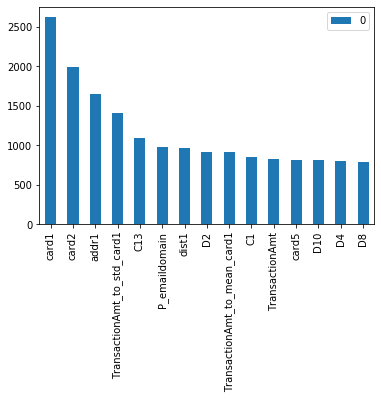

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import operator

#feature importance when fold = 5:
xgb_imp = {'V258': 79, 'C7': 60, 'V156': 58, 'C14': 554, 'C1': 847, 'V283': 178, 'V149': 64, 'V194': 9, 'V147': 16, 'C13': 1093, 'C2': 671, 'V38': 181, 'V45': 177, 'V87': 271, 'V42': 24, 'V332': 51, 'V268': 52, 'V245': 39, 'V189': 57, 'card3': 309, 'D13': 205, 'R_emaildomain': 468, 'V223': 17, 'C4': 114, 'V80': 36, 'V317': 238, 'V62': 212, 'id_33': 309, 'id_05': 463, 'V238': 18, 'V246': 23, 'card1': 2624, 'V205': 29, 'V12': 130, 'V322': 7, 'C11': 540, 'V184': 25, 'V169': 49, 'V266': 107, 'TransactionAmt_to_std_card1': 1411, 'id_13': 271, 'V294': 201, 'DeviceType': 89, 'V58': 39, 'V170': 22, 'V323': 35, 'V224': 54, 'id_02_to_mean_card1': 284, 'V172': 10, 'V43': 46, 'V155': 20, 'V218': 37, 'C12': 191, 'TransactionAmt_to_std_card4': 774, 'V208': 68, 'D15_to_std_card1': 546, 'V78': 210, 'V56': 173, 'V40': 44, 'D15_to_mean_addr1': 489, 'V225': 15, 'D12': 236, 'ProductCD': 182, 'D2': 921, 'V81': 98, 'V291': 110, 'id_31': 734, 'P_emaildomain': 979, 'TransactionAmt': 822, 'D8': 786, 'V187': 72, 'V207': 57, 'V261': 86, 'C8': 227, 'V198': 6, 'V257': 37, 'V44': 128, 'addr2': 49, 'V308': 150, 'V74': 75, 'V99': 78, 'TransactionAmt_to_mean_card4': 737, 'V200': 41, 'V313': 484, 'V262': 41, 'V282': 200, 'addr1': 1652, 'D3': 363, 'V259': 57, 'D4': 796, 'M5': 247, 'D15_to_mean_card1': 610, 'V221': 54, 'V324': 8, 'V175': 10, 'V57': 15, 'V244': 22, 'V39': 33, 'V315': 326, 'id_14': 105, 'D15': 265, 'V79': 39, 'V263': 41, 'V22': 3, 'V143': 50, 'D6': 180, 'V53': 160, 'V243': 45, 'V59': 20, 'id_20': 672, 'V209': 72, 'V277': 92, 'id_17': 120, 'V251': 33, 'V188': 18, 'id_38': 137, 'V174': 3, 'V19': 98, 'V256': 35, 'id_19': 496, 'id_06': 393, 'M4': 254, 'V162': 34, 'V267': 98, 'V47': 51, 'V49': 50, 'V269': 5, 'V154': 4, 'TransactionAmt_to_mean_card1': 912, 'V215': 57, 'V150': 70, 'V210': 22, 'id_01': 330, 'card6': 230, 'V20': 150, 'id_02': 262, 'C10': 226, 'V82': 217, 'V333': 19, 'D1': 689, 'card5': 815, 'V152': 58, 'id_09': 104, 'V264': 85, 'V63': 19, 'R_emaildomain_2': 36, 'V247': 11, 'V190': 8, 'V212': 40, 'id_02_to_std_card1': 291, 'D9': 387, 'V70': 55, 'V61': 159, 'V16': 6, 'V30': 53, 'V310': 315, 'V85': 39, 'V83': 210, 'V193': 8, 'id_03': 84, 'V153': 2, 'D14': 321, 'card2': 1988, 'C6': 441, 'V54': 144, 'V64': 54, 'V227': 14, 'V201': 21, 'V274': 55, 'V312': 212, 'V141': 7, 'V253': 29, 'V289': 88, 'D15_to_std_addr1': 229, 'V73': 39, 'C5': 280, 'V242': 19, 'DeviceInfo': 573, 'id_36': 22, 'D10': 811, 'V206': 47, 'V211': 36, 'V271': 76, 'V250': 20, 'V142': 6, 'V196': 2, 'V164': 70, 'V167': 12, 'V287': 40, 'V233': 33, 'V161': 24, 'V279': 52, 'V203': 59, 'V326': 22, 'V75': 97, 'id_30': 296, 'V314': 266, 'C9': 392, 'V168': 13, 'V335': 10, 'V307': 280, 'V13': 119, 'V160': 76, 'V280': 56, 'V96': 96, 'V36': 112, 'card4': 273, 'V306': 135, 'V148': 7, 'V163': 8, 'V91': 58, 'D15_to_mean_addr2': 134, 'V159': 75, 'V285': 160, 'V336': 35, 'V76': 158, 'V217': 26, 'id_34': 33, 'D11': 527, 'V128': 66, 'V71': 5, 'D15_to_mean_card4': 348, 'V131': 138, 'V35': 100, 'V126': 133, 'V130': 207, 'V97': 31, 'V273': 45, 'V37': 112, 'id_32': 54, 'V139': 96, 'V275': 27, 'dist1': 970, 'V90': 70, 'D5': 300, 'D15_to_std_addr2': 100, 'M6': 217, 'V165': 139, 'V11': 50, 'V158': 25, 'V265': 49, 'M3': 99, 'V95': 15, 'V288': 80, 'V166': 44, 'M9': 70, 'V229': 52, 'V92': 11, 'V199': 15, 'V7': 57, 'V9': 24, 'V50': 11, 'D15_to_std_card4': 118, 'P_emaildomain_2': 145, 'V34': 45, 'V48': 70, 'V52': 32, 'M8': 43, 'V195': 24, 'V151': 19, 'V234': 60, 'id_04': 36, 'V29': 59, 'V127': 134, 'V145': 35, 'V4': 71, 'V3': 27, 'V272': 22, 'V292': 47, 'id_37': 42, 'V222': 48, 'V51': 41, 'V33': 25, 'V278': 53, 'id_02_to_mean_card4': 219, 'V192': 7, 'V178': 22, 'M2': 33, 'V94': 49, 'V331': 14, 'V17': 12, 'V220': 54, 'V182': 12, 'V140': 24, 'V180': 25, 'V304': 19, 'V216': 47, 'V69': 63, 'P_emaildomain_1': 4, 'V157': 10, 'V84': 9, 'V10': 42, 'V226': 10, 'V204': 26, 'V21': 4, 'V2': 40, 'V177': 5, 'id_35': 12, 'V248': 13, 'id_02_to_std_card4': 99, 'V254': 28, 'V276': 48, 'V228': 25, 'V179': 6, 'M7': 62, 'V60': 34, 'V270': 59, 'V230': 24, 'V93': 6, 'V6': 44, 'V100': 13, 'V235': 14, 'V214': 36, 'V202': 45, 'V231': 11, 'V5': 111, 'V138': 6, 'V232': 32, 'V219': 26, 'V176': 17, 'V337': 10, 'V330': 2, 'V302': 2, 'V72': 10, 'V334': 19, 'id_11': 109, 'V329': 11, 'V8': 10, 'id_16': 1, 'id_15': 18, 'V46': 23, 'V146': 11, 'V339': 11, 'V239': 28, 'V249': 17, 'V260': 24, 'V171': 35, 'V144': 12, 'V185': 7, 'V338': 17, 'V236': 11, 'V173': 6, 'V327': 3, 'id_28': 12, 'V32': 13, 'V303': 16, 'V183': 9, 'V186': 8, 'V191': 3, 'V255': 4, 'V181': 6, 'V237': 8, 'V213': 14, 'V18': 6, 'V15': 9, 'id_10': 15, 'V325': 1, 'V252': 1, 'V240': 3, 'id_12': 2, 'M1': 2, 'id_29': 1, 'V31': 1}

xgb_imp = pd.DataFrame.from_dict(xgb_imp, orient = 'index')

xgb_imp = xgb_imp.sort_values(by = 0,ascending=False)

#select the top 15 most important features
xgb_imp = xgb_imp[0:15]

xgb_imp.plot.bar()